In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import cv2

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, randint

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import joblib
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, f1_score
from tqdm import tqdm
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

C:\Users\ASUS\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Brain Tumor Images
folder_path = 'Brain Tumor Data Set/Brain Tumor'
image_files_tumor = [file for file in os.listdir(folder_path)]

# Normal Brain Images
folder_path = 'Brain Tumor Data Set/Healthy'
image_files_normal = [file for file in os.listdir(folder_path)]

### Visualizing the data

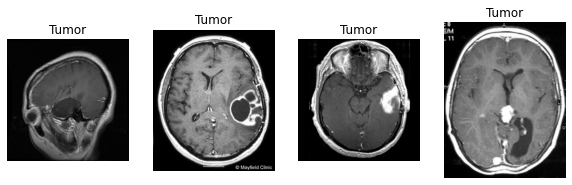

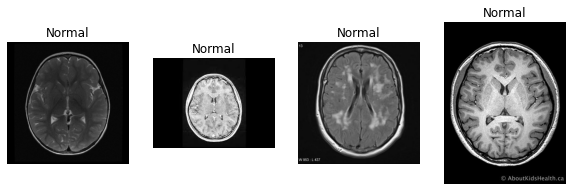

In [3]:
# Displaying Brain Tumor Images
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    ax[i].imshow(mpimg.imread('Brain Tumor Data Set/Brain Tumor/' + image_files_tumor[i+5]))
    ax[i].axis('off')
    ax[i].set_title('Tumor')
plt.show()

# Displaying Normal Brain Images
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    ax[i].imshow(mpimg.imread('Brain Tumor Data Set/Healthy/' + image_files_normal[i+5]))
    ax[i].axis('off')
    ax[i].set_title('Normal')
    
plt.show()

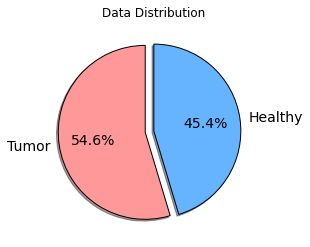

In [4]:
# visualizing the data distribution
data = {'Tumor': len(image_files_tumor), 'Healthy': len(image_files_normal)}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots()
ax.pie(values, labels=names, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'], explode=(0.1, 0), shadow=True, textprops={'fontsize': 14}, wedgeprops={'edgecolor': 'black'})
ax.set_title('Data Distribution')
plt.show()

In [5]:
url_tumor = 'Brain Tumor Data Set/Brain Tumor/'
url_healthy = 'Brain Tumor Data Set/Healthy/'

# Merging the data
data = []
data_gray = []
for file in image_files_tumor:
    # save the image and the label (1 for tumor)
    img = cv2.imread(url_tumor + file)
    resized_image = cv2.resize(img, (175,175), interpolation=cv2.INTER_AREA)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    data.append([resized_image, 1]) # 1 for tumor
    data_gray.append([grayscale_image, 1])
  
for file in image_files_normal:
    img = cv2.imread(url_healthy + file)
    resized_image = cv2.resize(img, (175,175), interpolation=cv2.INTER_AREA)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    data.append([resized_image, 0]) # 0 for normal
    data_gray.append([grayscale_image, 0])
    
# Creating a DataFrame
df = pd.DataFrame(data, columns=['image', 'label'])

# Shuffling the data
df = df.sample(frac=1).reset_index(drop=True)


In [6]:
df_gray =  pd.DataFrame(data_gray, columns=['image', 'label'])
df_gray = df_gray.sample(frac=1).reset_index(drop=True)

In [8]:
df_gray.head()

,image,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3,"[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...",0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


In [62]:
df.head(10)

,image,label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
1,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",1
2,"[[[50, 54, 59], [50, 54, 59], [50, 54, 59], [5...",1
3,"[[[107, 107, 107], [101, 101, 101], [101, 101,...",0
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
5,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",1
6,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
8,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
9,"[[[254, 254, 254], [254, 254, 254], [254, 254,...",1


In [10]:
# We have a meta data file that contains more information about the images

# Load the meta data
meta_data = pd.read_csv('metadata.csv', index_col=0)
meta_data.head()

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


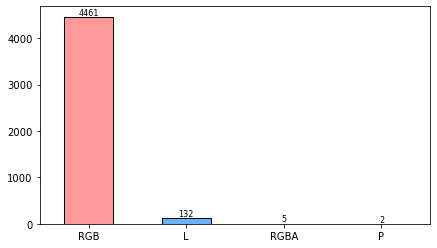

In [11]:
meta_data['mode'].value_counts().plot(kind='bar', color=['#ff9999','#66b3ff', '#ff55','#66b344'], rot=0, figsize=(7, 4), edgecolor='black')
for i, v in enumerate(meta_data['mode'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=8)

plt.show()

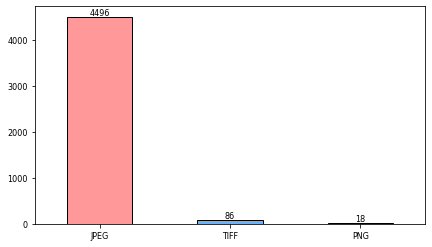

In [12]:
meta_data['format'].value_counts().plot(kind='bar', color=['#ff9999','#66b3ff','#99ff99'], figsize=(7, 4), edgecolor='black', fontsize=8, rot=0)
for i, v in enumerate(meta_data['format'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=8)


#### Step 1: Train and Test the model with RGB images

In [7]:
# Split the data
X = np.array(df['image'].values.tolist())
y = df['label'].values

In [8]:
X.shape

(4600, 175, 175, 3)

In [9]:
# Normalizing the data
X = X/ 255

In [10]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [12]:
y_test_cat = to_categorical(y_test, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_train_cat = to_categorical(y_train, num_classes=2)

In [63]:
# Flatten the image data
X_train_flat = np.array([x.flatten() for x in X_train])
X_val_flat = np.array([x.flatten() for x in X_val])

#### XGBoost model

In [ ]:
# Create the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='auc')

# Train the model without hyperparameter tuning
model.fit(X_train_flat, y_train)

# Make predictions
y_pred = model.predict(X_val_flat)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f'Initial Accuracy: {accuracy:.4f}')

# Perform hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 300)
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=1, scoring='accuracy', cv=3, n_jobs=-1, random_state=42, verbose=True)
random_search.fit(X_train_flat, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best accuracy: {random_search.best_score_:.4f}")

# Use the best model to make predictions
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val_flat)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy with best model: {accuracy:.4f}')


Initial Accuracy: 0.9633
Fitting 3 folds for each of 1 candidates, totalling 3 fits


#### Random Forest Model


In [64]:
# Create the Random Forest model with predefined parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train_flat, y_train)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val_flat)

# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f'Random Forest Validation Accuracy: {accuracy_rf:.4f}')

Random Forest Validation Accuracy: 0.9633


In [22]:
# Perform hyperparameter tuning with RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(100, 300),
    'max_depth': [None] + list(range(10, 31, 10)),
    'min_samples_split': randint(2, 11)
}

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist_rf, n_iter=4, refit='accuracy', scoring=scoring, cv=2, random_state=42, n_jobs=-1,verbose=True)
random_search_rf.fit(X_train_flat, y_train)

# Print the best parameters and the best score
print(f"Random Forest Best parameters: {random_search_rf.best_params_}")
print(f"Random Forest Best accuracy: {random_search_rf.best_score_:.4f}")

# Use the best model to make predictions
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_val_flat)

# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_pred_rf)
precision_rf = precision_score(y_val, y_pred_rf, average='weighted')
recall_rf = recall_score(y_val, y_pred_rf, average='weighted')
f1_rf = f1_score(y_val, y_pred_rf, average='weighted')
print(f'Random Forest Validation Accuracy: {accuracy_rf:.4f}')
print(f'Random Forest Validation Precision: {precision_rf:.4f}')
print(f'Random Forest Validation Recall: {recall_rf:.4f}')
print(f'Random Forest Validation F1 Score: {f1_rf:.4f}')


Fitting 2 folds for each of 4 candidates, totalling 8 fits
Random Forest Best parameters: {'max_depth': None, 'min_samples_split': 8, 'n_estimators': 221}
Random Forest Best accuracy: 0.9161
Random Forest Validation Accuracy: 0.9633
Random Forest Validation Precision: 0.9638
Random Forest Validation Recall: 0.9633
Random Forest Validation F1 Score: 0.9632


In [23]:
# save the rf model
joblib.dump(best_rf_model, 'random_search_rf.pkl')

['random_search_rf.pkl']

In [17]:
# load the rf model
loaded_rf_model = joblib.load('random_search_rf.pkl')

#### Principal Component Analysis (PCA)

In [25]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=8, random_state=42)

with tqdm(total=100, desc='Training Progress', unit='step') as pbar:
    # Update progress for each stage of training
    rf_model.fit(X_train_pca, y_train)
    pbar.update(100)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val_pca)

# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f'Random Forest Validation Accuracy with PCA: {accuracy_rf:.4f}')

Training Progress: 100%|███████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.38step/s]

Random Forest Validation Accuracy with PCA: 0.9620


##### Vizualizing the images after PCA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


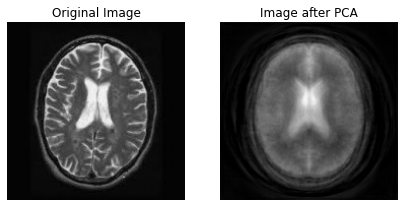

In [26]:

fig, ax = plt.subplots(1, 2, figsize=(7, 5))
ax[0].imshow(X_train_flat[8].reshape(175, 175, 3))
ax[0].axis('off')
ax[0].set_title('Original Image')

ax[1].imshow(pca.inverse_transform(X_train_pca[8]).reshape(175, 175, 3))
ax[1].axis('off')
ax[1].set_title('Image after PCA')

plt.show()


#### Train models with grayscale images

In [27]:
X_gray = df_gray['image'].values
y_gray = df_gray['label'].values

# Normalizing the data
X_gray = X_gray/ 255

# Splitting the data into training and testing sets
X_train_gray, X_test_gray, y_train_gray, y_test_gray = train_test_split(X_gray, y_gray, test_size=0.2, random_state=42, stratify=y_gray)

# Splitting the data into training and validation sets
X_train_gray, X_val_gray, y_train_gray, y_val_gray = train_test_split(X_train_gray, y_train_gray, test_size=0.2, random_state=42, stratify=y_train_gray)

# Flatten the image data
X_train_flat_gray = np.array([x.flatten() for x in X_train_gray])
X_val_flat_gray = np.array([x.flatten() for x in X_val_gray])


In [25]:
# Create the XGBoost model
model_gray = XGBClassifier(use_label_encoder=False, eval_metric='auc')

# Train the model without hyperparameter tuning
model_gray.fit(X_train_flat_gray, y_train_gray)

# Make predictions
y_pred_gray = model_gray.predict(X_val_flat_gray)

# Evaluate the model
accuracy_gray = accuracy_score(y_val_gray, y_pred_gray)

print(f'Initial Accuracy with grayscale images: {accuracy_gray:.4f}')

c:\Users\noa12\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Initial Accuracy with grayscale images: 0.9579


In [26]:
# save the xgboost model
joblib.dump(model_gray, 'xgboost_gray_model.pkl')

['xgboost_gray_model.pkl']

In [32]:
# Create the Random Forest model with predefined parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)

with tqdm(total=100, desc='Training Progress', unit='step') as pbar:
    # Update progress for each stage of training
    rf_model.fit(X_train_flat_gray, y_train_gray)
    pbar.update(100)

# rf_model.fit(X_train_flat, y_train)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val_flat_gray)

# Evaluate the model
accuracy_rf = accuracy_score(y_val_gray, y_pred_rf)
print(f'Random Forest Validation Accuracy: {accuracy_rf:.4f}')

Training Progress: 100%|███████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.01step/s]

Random Forest Validation Accuracy: 0.9470


In [33]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_flat_gray)
X_val_pca = pca.transform(X_val_flat_gray)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=8, random_state=42)

with tqdm(total=100, desc='Training Progress', unit='step') as pbar:
    # Update progress for each stage of training
    rf_model.fit(X_train_pca, y_train_gray)
    pbar.update(100)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val_pca)

# Evaluate the model
accuracy_rf = accuracy_score(y_val_gray, y_pred_rf)
print(f'Random Forest Validation Accuracy with PCA: {accuracy_rf:.4f}')

Training Progress: 100%|███████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28step/s]

Random Forest Validation Accuracy with PCA: 0.9592


In [27]:
# def resize_images(images):
#     resized_images = np.zeros((images.shape[0], 224, 224, 3))
#     for i in range(images.shape[0]):
#         resized_images[i] = tf.image.resize(images[i], (224, 224)).numpy()
#     return resized_images

In [67]:
X.shape

(10, 224, 224, 3)

In [14]:
# X_train_resized = resize_images(X_train)
# X_val_resized = resize_images(X_val)

# Define ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True, zoom_range=0.2)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val_cat, batch_size=32)

In [15]:
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(175, 175, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 173, 173, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 86, 86, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 84, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 42, 42, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 128)      

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1,restore_best_weights=True)

In [ ]:
history = model.fit(
    train_generator,
    epochs=18,
    validation_data=val_generator,
    callbacks=[early_stopping]
)


Epoch 1/18
92/92 [==============================] - 39s 423ms/step - loss: 0.1399 - accuracy: 0.9474 - val_loss: 0.2296 - val_accuracy: 0.9293
Epoch 2/18
92/92 [==============================] - 41s 450ms/step - loss: 0.1191 - accuracy: 0.9575 - val_loss: 0.1760 - val_accuracy: 0.9457
Epoch 3/18
92/92 [==============================] - 42s 455ms/step - loss: 0.1273 - accuracy: 0.9552 - val_loss: 0.1221 - val_accuracy: 0.9620
Epoch 4/18
92/92 [==============================] - 41s 447ms/step - loss: 0.1060 - accuracy: 0.9596 - val_loss: 0.1774 - val_accuracy: 0.9429
Epoch 5/18
92/92 [==============================] - 41s 440ms/step - loss: 0.1009 - accuracy: 0.9616 - val_loss: 0.1321 - val_accuracy: 0.9660
Epoch 6/18
66/92 [====================>.........] - ETA: 10s - loss: 0.1046 - accuracy: 0.9626

In [ ]:
loss,accuracy = model.evaluate(X_test,y_test_cat, verbose=0)
print(f"Loss: {loss} Accuracy: {accuracy}")